In [44]:
import numpy as np
from numpy import inner,sqrt,sin,cos,arctan2,pi,add,array,zeros,sum,arccos,log
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pylab as plt
from scipy.stats import rv_continuous

First, lets get familar with the random number generator
==

We use Numpy's random number generator (rng, imported above).  

This is a random number between 0 and 1: 0.9511226797303592
This is two random numbers between 0 and 1: 0.25711640901465727 0.04928290256315737
This is a random number between s and t: 5.1976891116773185
This is a histogram of 1000 random numbers between 0 and 1 using 10 bins:


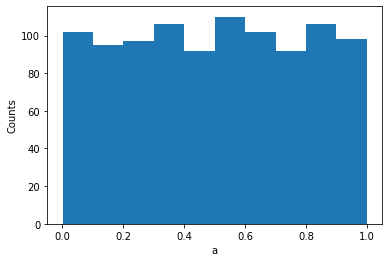

In [26]:
a = rng.random()
print("This is a random number between 0 and 1:",a)

a = rng.random(2)
print("This is two random numbers between 0 and 1:",a[0],a[1])

s=5.0
t=5.8
a = s + rng.random()*(t-s)
print("This is a random number between s and t:",a)

a = rng.random(1000)
print("This is a histogram of 1000 random numbers between 0 and 1 using 10 bins:")
plt.hist(a,bins=10)
plt.xlabel("a")
plt.ylabel("Counts")
plt.show()

Sampling Distriubtions
==

Often we want to sample distributions other than the uniform distribution from 0 to 1.  Above we have done a uniform distribution from s to t by scaling the output of the uniform distribution from 0 to 1.  We can do non uniform distributions to.

Example, pick two random numbers in the range and domain of a function.  So for f(x) = sin^2(x), choose a random x between 0 and pi, and a random y between min(f(x)) and max(f(x)).  If this (x,y) is less than (x,f(x)), use x as your random sample from the distribution.  If not, pick another random x and y and repeat until a pair works.

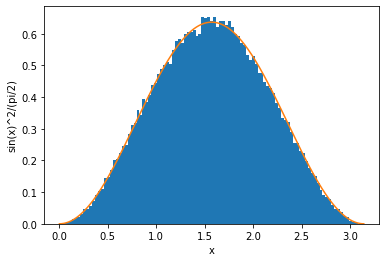

In [117]:
a = zeros(100000)
for i in range(len(a)):
    x = rng.random()*pi
    y = rng.random()
    while y>sin(x)**2:
        x = rng.random()*pi
        y = rng.random()            
    a[i]=x
plt.hist(a,bins=100,density=True)
plt.plot(np.linspace(0,np.pi,1000),2.0/pi*sin(np.linspace(0,np.pi,1000))**2)
plt.xlabel("x")
plt.ylabel("sin(x)^2/(pi/2)")
plt.show()

Let's define a function for easy use

A single value between 0 and pi weigthed by sin2: 1.5767637451249739


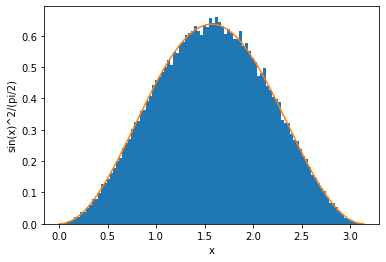

In [115]:
def random_sin2():
    x = rng.random()*pi
    y = rng.random()
    while y>sin(x)**2:
        x = rng.random()*pi
        y = rng.random()            
    return x

print("A single value between 0 and pi weigthed by sin2:", random_sin2())

a = array([ random_sin2() for x in range(100000) ])

plt.hist(a,bins=100,density=True)
plt.plot(np.linspace(0,np.pi,1000),2.0/pi*sin(np.linspace(0,np.pi,1000))**2)
plt.xlabel("x")
plt.ylabel("sin(x)^2/(pi/2)")
plt.show()

Random Velocities in 3-space (i.e. isotropic emission)
==

You may think in order to get a random velocities you could choose three random numbers (x,y,z) between -1 and 1, and then normalize the resulting vector.  This however, is incorrect.  It is not uniform.  One way to do it is to choose two random angles, a random phi between 0 and 2*pi and a random cost(theta) between -1 and 1 (note, not a random theta between 0 and pi, that is a different distribution).



A random direction in 3-space is: [-0.43723838 -0.76730899 -0.46910501]
The phi is  4.194446115169259  and the costheta is  -0.4691050118389444


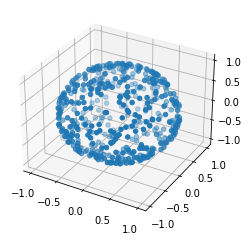

In [116]:
phi = rng.random()*2.0*pi #uniform random between 0 and 2pi
costheta = 2.0*rng.random()-1.0 #unifrom random between -1 and 1
sintheta = sqrt(1.0-costheta**2) #need sin(theta) for the cartesian cordinates
direction = array([sintheta*cos(phi),sintheta*sin(phi),costheta])
print("A random direction in 3-space is:",direction)
print("The phi is ",phi," and the costheta is ",costheta)

def random_direction():
    phi = rng.random()*2.0*pi #uniform random between 0 and 2pi
    costheta = 2.0*rng.random()-1.0 #unifrom random between -1 and 1
    sintheta = sqrt(1.0-costheta**2) #need sin(theta) for the cartesian cordinates
    return array([sintheta*cos(phi),sintheta*sin(phi),costheta])
    
a = array([ random_direction() for x in range(500) ])

ax = plt.axes(projection='3d')
ax.scatter3D(a.T[0],a.T[1],a.T[2])
plt.show()
